# Torrando café com Tensorflow

Neste código nós construíremos uma pequena rede neural usando Tensorflow


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


## Conjunto de dados

Abaixo nós definimos uma função que permite criar dados para o processo de torrefação de café.

In [28]:
def cria_dados_torrefacao_cafe():
    """ Cria um conjunto de dados para o processo de torrefação de café.
        Duração da torrefação: 12-15 minutos é o melhor
        Intervalo de temperatura: 175-260C é o melhor
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min é o melhor
    X[:,0] = X[:,0] * (285-150) + 150  # (175-260 C) é o melhor
    Y = np.zeros(len(X))

    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))


In [29]:
X,Y = cria_dados_torrefacao_cafe();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Vamos plotar os dados de torrefação de café abaixo. As duas características são a temperatura em graus Celsius e a duração em minutos. Algumas referências sugerem que o melhor café é obtido quando a duração é mantida dentro do intervalo de 12 a 15 minutos enquanto a temperatura deve estar entre 175 e 260 graus. Naturalmente, à medida com que a temperatura aumenta, a duração deve ser menor.

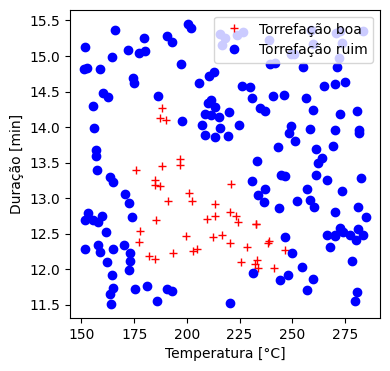

In [30]:
pos = Y.reshape(-1,) == 1 # identifica os elementos em y que são iguais a 1
neg = Y.reshape(-1,) == 0 # identifica os elementos em y que são iguais a 0

fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(X[pos,0], X[pos,1], 'r+', label="Torrefação boa")
ax.plot(X[neg,0], X[neg,1], 'bo', label="Torrefação ruim")

#ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('Duração [min]')
ax.set_xlabel('Temperatura [°C]')
ax.legend(loc="upper right")
plt.show()

### Normalizando os dados

Para treinar parâmetros adequados para a nossa rede neural, o tensorflow usa uma técnica conhecido como propagação para trás (backpropagation). Esse procedimento torna-se mais rápido se os dados estiverem normalizados. Trata-se do mesmo procedimento (escalonamento de características) já visto, onde as características são normalizadas para que tenham um intervalo parecido de valores.

O procedimento abaixo usa uma camada de normalização do Keras (https://keras.io/api/layers/preprocessing_layers/numerical/normalization/).

Ela possui as seguintes etapas:
- ETAPA 1: cria uma "camada de normalização". Note que, conforme aplicado aqui, isso não é uma camada do seu modelo.
- ETAPA 2: 'adapta' os dados. Esse comando aprende a média e a variância do conjunto de dados e salva os valores internamente.
- ETAPA 3: normaliza os dados

Lembre-se que é importante aplicar essa normalização para quaisquer dados de características futuros que venham a ser utilizados no modelo já treinado.

In [31]:
print(f"Temperatura Max, Min pré normalização: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duração     Max, Min pré normalização: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
camada_norm = tf.keras.layers.Normalization(axis=-1)
camada_norm.adapt(X)  # calcula média e variância
Xn = camada_norm(X) # características normalizadas
print(f"Temperatura Max, Min pós normalização: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duração     Max, Min pós normalização: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperatura Max, Min pré normalização: 284.99, 151.32
Duração     Max, Min pré normalização: 15.45, 11.51
Temperatura Max, Min pós normalização: 1.66, -1.69
Duração     Max, Min pós normalização: 1.79, -1.70


Abaixo nós estamos duplicando nosso conjunto de dados de treinamento em 1000 vezes, passando de 200 amostras para 200000. Isso reduz o número de épocas necessárias para o treinamento do modelo. É definição de "Época" é dada logo mais neste código. Essa estratégia pode ser usada sempre que o número de amostras no conjuto de dados de treinamento for pequeno ($<1000$, por exemplo).

In [32]:
X_maior = np.tile(Xn,(1000,1))
Y_maior = np.tile(Y,(1000,1))

print(X_maior.shape, Y_maior.shape)

(200000, 2) (200000, 1)


## Modelo Tensorflow

### Modelo

Vamos agora construir a Rede Neural para torrefação de café descrita nos slides.
Usaremos duas camadas com ativações do tipo sigmoide, conforme mostrado abaixo.

In [33]:
numero_de_caracteristicas = X_maior.shape[1]

modelo = Sequential(
    [
        tf.keras.Input(shape=(numero_de_caracteristicas,)),
        Dense(3, activation='sigmoid', name = 'camada1'),
        Dense(1, activation='sigmoid', name = 'camada2')
     ]
)

>**OBS:** O comando `tf.keras.Input(shape=(numero_de_caracteristicas,)),`
especifica o shape esperado para a entrada da rede neural. Isso permite que o Tensorflow já saiba o número de parâmetros $w$ e $b$ da rede antecipadamente. Na prática, esse comando pode ser omitido. Nesse caso, o Tensorflow irá ajustar o número de entradas da rede quando os dados de entrada forem especificados pelo comando `modelo.fit`.

O comando `modelo.summary()` nos fornece uma descrição da rede que acabamos de criar:

In [34]:
modelo.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ camada1 (Dense)                      │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ camada2 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

A contagem de parâmetros mostrada acima corresponde ao número de elementos nas arrays de peso e de bias conforme mostrado abaixo.

In [35]:
param_camada1 = 2 * 3 + 3   # parâmetros W1 + parâmetros b1
param_camada2 = 3 * 1 + 1   # parâmetros W2 + parâmetros b2
print("Número de parâmetros camada 1 = ", param_camada1, ", Número de parâmetros camada 1 = ", param_camada2  )

Número de parâmetros camada 1 =  9 , Número de parâmetros camada 1 =  4


Vamos examinar os valores que o Tensorflow usou para inicializar os pesos da nossa rede.  O shape dos pesos $W$ numa camada da rede deve ser (número de características na sua entrada, número de unidades/neurônios na camada).
Já o shape dos termos de bias $b$ de uma camada deve ser igual ao número de unidades/neurônios presente na camada.
- Na primeira camada da nossa rede, que possui 3 unidades/neurônios, esperamos que $W$ tenha tamanho (2,3) e que $b$ tenha 3 elementos.
- Na segunda camada da nossa rede, que possui apenas 1 unidade/neurônio, esperamos que $W$ tenha tamanho (3,1) e $b$ tenha 1 elemento.

In [36]:
W1, b1 = modelo.get_layer("camada1").get_weights()  # acessando os parâmetros da camada 1
W2, b2 = modelo.get_layer("camada2").get_weights()  # acessando os parâmetros da camada 2
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.67422765  0.7552489   0.8851788 ]
 [-0.32783693 -1.0425103  -1.069242  ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.6034915 ]
 [-0.43697125]
 [-0.09894371]] 
b2(1,): [0.]


Os 2 comandos usados a seguir serão explicados em mais detalhes nas aulas seguintes. Por enquanto, basta sabermos que:
- O comando `modelo.compile` irá definir a função de perda e irá especificar o tipo de otimização utilizada.
- O comando `modelo.fit` roda o Método do Gradiente para ajustar os parâmetros do modelo aos dados.

In [37]:
modelo.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

modelo.fit(
    X_maior,Y_maior,
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2621
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.1145
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0310
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0154
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0103
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0071
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0053
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0038
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0027
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0020


#### Parâmetros atualizados:

Agora que já treinamos o modelo, note que os valores dos seus 13 parâmetros foram atualizados:

In [38]:
W1, b1 = modelo.get_layer("camada1").get_weights()
W2, b2 = modelo.get_layer("camada2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-10.978927    -0.10005398  14.568623  ]
 [ -0.17804968  -9.037984    12.129552  ]] 
b1: [-11.948901 -11.240936   1.856831]
W2:
 [[-50.76558 ]
 [-46.7826  ]
 [-42.874958]] 
b2: [26.680752]


#### Lotes e épocas

O método do **gradiente clássico** que estudamos até agora usava, em cada iteração, todas as amostras do conjunto de dados de treinamento para realizar um passo de atualização dos parâmetros da rede.

Acontece que esse método clássico é muito custoso computacionalmente. Basta você pensar que, se o número de exemplos de treinamento é grande (por exemplo, 200 mil), cada amostra com 2 características, pelo menos 400 mil valores são computados em cada iteração.

Buscando tornar o processo de treinamento do modelo mais eficiente computacionalmente, surgiu o **método do gradiente em mini-lotes** (ou, em inglês, mini-batch gradient descent).

No método do gradiente em mini-lotes, o conjunto de dados de treinamento é dividido em 'lotes de amostras'. O tamanho padrão de cada lote no Tensorflow é de 32 exemplos de treinamento.
Como há 200000 amostras no nosso conjunto de dados expandido, isso significa que teremos 200000/32=6250 lotes.
Assim, em cada iteração, o método do gradiente opera em cima de apenas um desses lotes de amostras, passando para o lote seguinte na iteração seguinte.

Ao passar por todos os 6250 mini-lotes de amostra, significa que o método do gradiente completou sua primeira 'varredura' em cima do conjunto completo de dados. O número de varreduras que é feita em cima de todos os dados é também chamado de 'número de épocas'.


Com o comando `fit` acima, note que o número de épocas foi definido como sendo 10. Isso significa que o conjunto completo de dados foi aplicado ("varrido") 10 vezes no processo de treinamento do modelo. Durante o treinamento do modelo, o progresso de treinamento é mostrado conforme abaixo:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
A primeira linha, `Epoch 1/10`, descreve a época na qual o modelo encontra-se rodando atualmente em relação ao total.

#### Carregando um conjunto de pesos conhecidos

A seguir, nós carregamos alguns pesos salvos a partir de um treinamento feito anteriormente. Isso é para que este notebook torne-se robusto a mudanças do Tensorflow ao longo do tempo. Cada vez que rodamos o Tensorflow para um problema podemos obter pesos diferentes.

Sinta-se livre para rodar novamente o código considerando os próprios parâmetros que você treinou para a rede, comparando então os resultados.

In [39]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
modelo.get_layer("camada1").set_weights([W1,b1])
modelo.get_layer("camada2").set_weights([W2,b2])

### Previsões com o modelo

Uma vez que você treinou o modelo, você pode então usá-lo para realizar previsões.
Lembre-se que a saída do nosso modelo é uma probabilidade. Nesse caso, é a probabilidade de uma boa torra para o café. Para tomar uma decisão, precisamos aplicar um valor de limiar à probabilidade. Nesse caso, vamos usar um limiar de 0.5.

O modelo recebe um ou mais exemplos, cada exemplo numa linha da matriz. Nesse caso, nós temos duas características, tal que a matriz será (m,2), onde m é o número de exemplos que usaremos no nosso modelo.


Para realizar uma previsão, usamos o comando `predict`.



In [40]:
probabilidades = modelo.predict(Xn) # Xn são as características normalizadas do nosso conjunto de dados de treinamento

ychapeu = np.zeros_like(probabilidades)
for i in range(len(probabilidades)):
    if probabilidades[i] >= 0.5:
        ychapeu[i] = 1
    else:
        ychapeu[i] = 0

print("Taxa de acerto para os dados de treinamento:", (np.mean(Y == ychapeu) * 100))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Taxa de acerto para os dados de treinamento: 100.0


### Previsões com novos dados

Vamos agora criar novos dados e verificar as previsões feitas pelo modelo. Vamos começar criando os dados de entrada.

Lembre-se, nós normalizamos as características de entrada com base nos dados de treinamento. Portanto, temos que também normalizar esse nosso novo conjunto de dados de teste.

In [41]:
X_teste = np.array([
    [200,13.9],  # exemplo positivo (espera-se que seja igual a 1)
    [200,17]])   # exemplo negativo (espera-se que seja igual a 0)
X_teste_norm    = camada_norm(X_teste)
probabilidades  = modelo.predict(X_teste_norm)
print(f"probabilidades = \n", f"{probabilidades}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
probabilidades = 
 [[9.625127e-01]
 [3.031606e-08]]


Ou seja, supondo uma temperatura de torrefação de 200 graus Celsius, o nosso modelo prevê:

- Uma probabilidade do café resultante ser bom de 96.25%, caso a duração de torrefação seja de 13.9 minutos.
- Uma probabilidade do café resultante ser bom de praticamente 0%, caso a duração de torrefação seja de 17 minutos.

Para converter as probabilidade numa decisão, nós usamos um valor de limiar:

In [42]:
ychapeu = np.zeros_like(probabilidades)
for i in range(len(probabilidades)):
    if probabilidades[i] >= 0.5:
        ychapeu[i] = 1
    else:
        ychapeu[i] = 0
print(f"decisões = \n{ychapeu}")

decisões = 
[[1.]
 [0.]]


Também podemos fazer isso de forma mais sucinta:

In [43]:
ychapeu = (probabilidades >= 0.5).astype(int)
print(f"decisões = \n{ychapeu}")

decisões = 
[[1]
 [0]]


## Parabéns!

Você criou e treinou uma pequena rede neural usando Tensorflow.
A rede demonstrou a habilidade das redes neurais em lidar com decisões complexas dividindo as decisões entre múltiplas unidades (neurônios).

#Parte 2

#A fronteira de decisão#
Representa o limite no espaço de entrada onde a rede “decide” entre diferentes classes ou valores-alvo com base em suas previsões, destacando as regiões em que um conjunto de condições leva a uma classe específica ou outra.

Separação entre a classe 0 e 1. Probabilidade de 0,5 de pertencer a uma ou a outra classe.

Alguns valores de temperatura e duração que definem a fronteira de decisão:

In [85]:
X_teste = np.array([
[211.36, 11.96],
[231.82, 12.87],
[174.55, 13.47],
[174.55, 13.53],
[174.55, 13.58],
])
X_teste_norm    = camada_norm(X_teste)
probabilidades  = modelo.predict(X_teste_norm)
print(f"probabilidades = \n", f"{probabilidades}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
probabilidades = 
 [[0.4954785 ]
 [0.4819898 ]
 [0.47415346]
 [0.4919593 ]
 [0.5067764 ]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


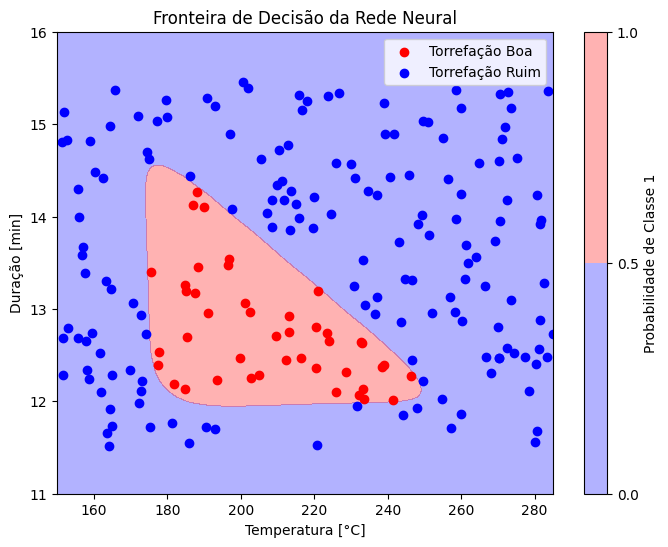

In [86]:
# Definindo os valores de Temperatura e Duração para a grade de pontos
temp_range = np.linspace(150, 285, 100)
dur_range = np.linspace(11, 16, 100)
temp_grid, dur_grid = np.meshgrid(temp_range, dur_range)
grid_points = np.c_[temp_grid.ravel(), dur_grid.ravel()]

# Normalizando os pontos da grade
grid_points_norm = camada_norm(grid_points)

# Calculando as probabilidades para cada ponto na grade
probabilidades_grid = modelo.predict(grid_points_norm).reshape(temp_grid.shape)

# Plotando a fronteira de decisão
plt.figure(figsize=(8, 6))
plt.contourf(temp_grid, dur_grid, probabilidades_grid, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
plt.colorbar(label="Probabilidade de Classe 1")
plt.xlabel("Temperatura [°C]")
plt.ylabel("Duração [min]")

# Adicionando os dados reais
plt.scatter(X[pos, 0], X[pos, 1], color="red", label="Torrefação Boa")
plt.scatter(X[neg, 0], X[neg, 1], color="blue", label="Torrefação Ruim")
plt.legend(loc="upper right")
plt.title("Fronteira de Decisão da Rede Neural")
plt.show()
